# Create track lines from points

Tracker records location information as points. However, you may have noticed that the Tracker web and mobile apps render lines. In this guide we'll show how you can do this too.

We're going to create some polylines from some tracks recorded while mountain biking in Palm Springs, CA. We'll also show how these lines can be stored in a new hosted feature layer.

In [1]:
import json
import datetime
import arcgis
from arcgis.gis import GIS
from arcgis.apps.tracker import TrackView

### Connect to our GIS

In [2]:
gis = GIS("https://tracker8.dev.geocloud.com/portal", "admin", verify_cert=False)
track_view = TrackView(gis.content.get("f467d6408d264adfb323a81fb4c144eb"))

Enter password: ········


### Define some parameters

Let's select a user and a time range for the tracks.

In [3]:
username = 'apulver'
start_time_utc = '2019-03-03 18:10:00'
end_time_utc = '2019-03-03  20:30:00'

### Query the tracks

Let's query the tracks and create a spatially enabled dataframe.

In [4]:
where_clause = f"created_user='{username}' AND location_timestamp > timestamp '{start_time_utc}' AND location_timestamp < timestamp '{end_time_utc}'"
track_view.tracks_layer.filter = where_clause
tracks_df = track_view.tracks_layer.query(where=where_clause, as_df=True, order_by_fields="location_timestamp", out_sr=4326)
tracks_df.head()

,SHAPE,activity,altitude,app_id,battery_percentage,battery_state,course,created_date,created_user,device_id,...,horizontal_accuracy,last_edited_date,last_edited_user,location_source,location_timestamp,objectid,session_id,signal_strength,speed,vertical_accuracy
0,"{'x': -116.49337974999997, 'y': 33.79124403600...",0,109.713160,tracker,99.0,1,40.884618,2019-03-03 18:17:05.644000053,apulver,None,...,4.000604,2019-03-03 18:17:05.644000053,apulver,None,2019-03-03 18:10:11.993999958,319939,None,None,0.596231,3.0
1,"{'x': -116.49325865699996, 'y': 33.79126289400...",0,108.165295,tracker,99.0,1,84.042459,2019-03-03 18:17:05.644000053,apulver,None,...,4.000604,2019-03-03 18:17:05.644000053,apulver,None,2019-03-03 18:10:21.993999958,319940,None,None,1.390870,3.0
2,"{'x': -116.49314836099995, 'y': 33.79125825500...",0,106.033945,tracker,99.0,1,70.831924,2019-03-03 18:17:05.644000053,apulver,None,...,4.000604,2019-03-03 18:17:05.644000053,apulver,None,2019-03-03 18:10:27.993999958,319941,None,None,2.100782,3.0
3,"{'x': -116.49302956499997, 'y': 33.79127848400...",0,103.582772,tracker,99.0,1,100.926768,2019-03-03 18:17:05.644000053,apulver,None,...,4.000604,2019-03-03 18:17:05.644000053,apulver,None,2019-03-03 18:10:32.993999958,319942,None,None,1.384817,3.0
4,"{'x': -116.49291089699994, 'y': 33.79125948900...",0,103.725729,tracker,99.0,1,133.862282,2019-03-03 18:17:05.644000053,apulver,None,...,6.000906,2019-03-03 18:17:05.644000053,apulver,None,2019-03-03 18:10:37.993999958,319943,None,None,2.091913,3.0


### Show the tracks on a map
Let's see what this data looks like in the map


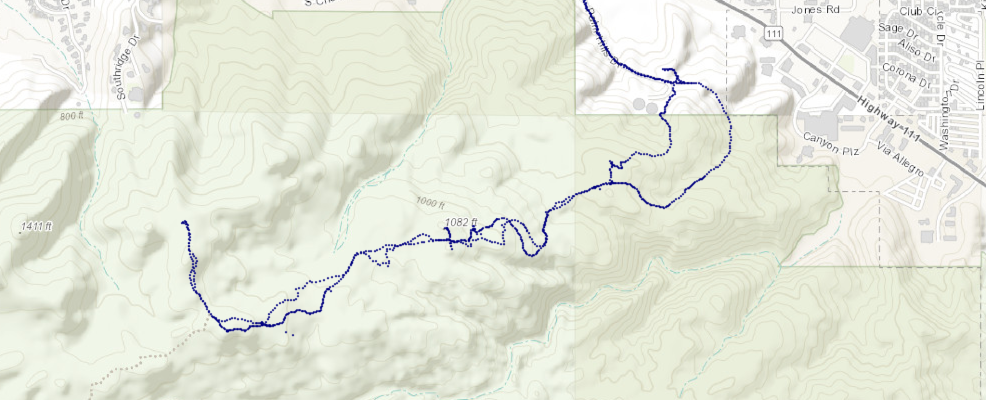

In [5]:
centroid = tracks_df.spatial.centroid
webmap = gis.map(f"{centroid[1]},{centroid[0]}", zoomlevel=15)
webmap.add_layer(track_view.tracks_layer, {"renderer":{"type":"simple","symbol":{"color":[0,0,128,255],"size":1,"type":"esriSMS","style":"esriSMSCircle"}}})
webmap

### Create a function to evaluate if a track point should be included in the line

This function applies the "smart rendering" logic to determine if the point should be included in the line.

In [6]:
def meets_inclusion_criteria(row):
    if row["horizontal_accuracy"] <= 10:
        return True
    if row["horizontal_accuracy"] <= 25 and (row["speed"] >=0 or row["course"] >=0):
        return True
    if row["speed"] >=0 and row["course"] >=0:
        return True
    return False

### Create a function to build track line features from the points

This is the heart of the notebook. It iterates over all of the points and builds one or more polylines. Each polyline has one or more paths. Each path contains the vertices that make up the line. The start and end times of each polyline is calculated and stored.

In [7]:
def create_track_line_features(tracks_df):
    vertices = []
    paths = []
    features = []
    for i, row in tracks_df.iterrows():
        if not meets_inclusion_criteria(row):
            continue
        if i <= 0:
            vertices.append(row)
            continue
        
        # Check if a new feature should be created
        previous_row = tracks_df.iloc[i-1]
        distance = arcgis.geometry.Point(json.dumps(row["SHAPE"])).distance_to(arcgis.geometry.Point(json.dumps(previous_row["SHAPE"])))
        time_delta = row["location_timestamp"] - previous_row["location_timestamp"]
        if distance > 500 and time_delta.seconds > 600:
            
            # add path for remaining vertices
            paths.append(vertices)
            vertices = []
            p = []
            for path in paths:
                p.append([[v["SHAPE"]['x'], v["SHAPE"]['y']] for v in path])
                
            features.append(arcgis.features.Feature(geometry=arcgis.geometry.Polyline({
                "paths": p,
                "spatialReference": tracks_df.spatial.sr
            }), attributes={
                "username": row["created_user"],
                "start_time": int(1000*paths[0][0]["location_timestamp"].timestamp()),
                "end_time": int(1000*row["location_timestamp"].timestamp())
            }))
            paths = []
        
        if len(vertices) >= 100:
            paths.append(vertices)
            vertices = [vertices[-1]]
            
        # Add a vertext to the line
        vertices.append(row)

    # Handle remaining vertices as a new path
    if len(vertices) > 1:
        paths.append(vertices)
    
    # Handle remaining paths as new features
    if len(paths) > 0:
        p = []
        for path in paths:
            p.append([[v["SHAPE"]['x'], v["SHAPE"]['y']] for v in path])
        features.append(arcgis.features.Feature(geometry=arcgis.geometry.Polyline({
            "paths": p,
            "spatialReference": tracks_df.spatial.sr
        }), attributes={
            "username": row["created_user"],
            "start_time": int(1000*paths[0][0]["location_timestamp"].timestamp()),
            "end_time": int(1000*row["location_timestamp"].timestamp())
        }))
    return features

### Create new feature service to store the lines

A new hosted feature service with a single polyline layer is created.

In [8]:
name = f"track_lines_from_python_{int(datetime.datetime.now().timestamp()*1000)}"
item = gis.content.create_service(name, create_params={"name": name, "capabilities": "Query,Create,Update"})
feature_service = arcgis.features.FeatureLayerCollection.fromitem(item)
feature_service.manager.add_to_definition(
    json.loads("""{"layers":[{"currentVersion":10.51,"id":0,"name":"Track Lines","type":"Feature Layer","displayField":"","description":"","copyrightText":"","defaultVisibility":true,"editingInfo":{"lastEditDate":1526947149024},"relationships":[],"isDataVersioned":false,"supportsAppend":true,"supportsCalculate":true,"supportsTruncate":true,"supportsAttachmentsByUploadId":true,"supportsAttachmentsResizing":true,"supportsRollbackOnFailureParameter":true,"supportsStatistics":true,"supportsAdvancedQueries":true,"supportsValidateSql":true,"supportsCoordinatesQuantization":true,"supportsApplyEditsWithGlobalIds":false,"supportsMultiScaleGeometry":true,"hasGeometryProperties":true,"geometryProperties":{"shapeLengthFieldName":"Shape__Length","units":"esriMeters"},"advancedQueryCapabilities":{"supportsPagination":true,"supportsPaginationOnAggregatedQueries":true,"supportsQueryRelatedPagination":true,"supportsQueryWithDistance":true,"supportsReturningQueryExtent":true,"supportsStatistics":true,"supportsOrderBy":true,"supportsDistinct":true,"supportsQueryWithResultType":true,"supportsSqlExpression":true,"supportsAdvancedQueryRelated":true,"supportsCountDistinct":true,"supportsLod":true,"supportsReturningGeometryCentroid":false,"supportsReturningGeometryProperties":true,"supportsQueryWithDatumTransformation":true,"supportsHavingClause":true,"supportsOutFieldSQLExpression":true},"useStandardizedQueries":true,"geometryType":"esriGeometryPolyline","minScale":0,"maxScale":0,"extent":{"xmin":-20037508.342788905,"ymin":-8175201.3721496435,"xmax":-10018754.171394452,"ymax":12175461.54272524,"spatialReference":{"wkid":102100}},"drawingInfo":{"renderer":{"type":"simple","symbol":{"type":"esriSLS","style":"esriSLSSolid","color":[165,83,183,255],"width":1}},"transparency":0,"labelingInfo":null},"allowGeometryUpdates":true,"hasAttachments":false,"htmlPopupType":"esriServerHTMLPopupTypeNone","hasMetadata":true,"hasM":false,"hasZ":false,"objectIdField":"OBJECTID","uniqueIdField":{"name":"OBJECTID","isSystemMaintained":true},"globalIdField":"","typeIdField":"","fields":[{"name": "start_time", "type": "esriFieldTypeDate", "alias": "Start Time", "nullable": true, "editable": true}, {"name": "end_time", "type": "esriFieldTypeDate", "alias": "End Time", "nullable": true, "editable": true},{"name": "username", "type": "esriFieldTypeString", "alias": "Username", "nullable": true, "editable": true},{"name":"OBJECTID","type":"esriFieldTypeOID","alias":"OBJECTID","sqlType":"sqlTypeOther","nullable":false,"editable":false,"domain":null,"defaultValue":null}],"indexes":[],"types":[],"templates":[{"name":"New Feature","description":"","drawingTool":"esriFeatureEditToolLine","prototype":{"attributes":{}}}],"supportedQueryFormats":"JSON, geoJSON","hasStaticData":false,"maxRecordCount":2000,"standardMaxRecordCount":4000,"tileMaxRecordCount":4000,"maxRecordCountFactor":1,"capabilities":"Query,Editing,Create,Update,Delete,Sync","syncEnabled":true,"adminLayerInfo":{"geometryField":{"name":"Shape","srid":102100}}}],"tables":[]}""")
)

{'layers': [{'name': 'Track Lines', 'id': 0}], 'success': True}

### Add features to the layer

The polylines are generated and then added to the previously created feature layer.

In [9]:
features = create_track_line_features(tracks_df)
feature_service.layers[0].edit_features(adds=features)

{'addResults': [{'objectId': 1, 'success': True}],
 'updateResults': [],
 'deleteResults': [],
 'attachments': {'addResults': [], 'updateResults': [], 'deleteResults': []}}

### Show the lines in a webmap

Finally, we'll load the new service and show it in a map.


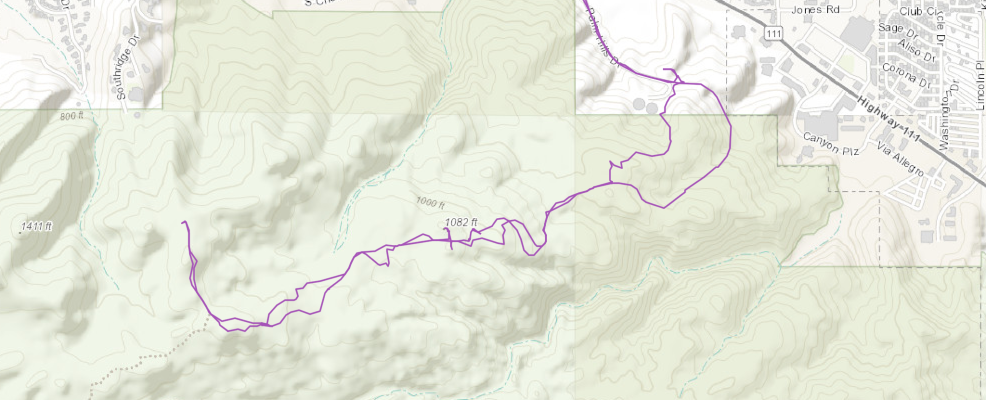

In [10]:
webmap = gis.map(f"{centroid[1]},{centroid[0]}", zoomlevel=15)
webmap.add_layer(feature_service.layers[0])
webmap